In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup as bs
import requests as rq
import seaborn as sns

In [30]:
def gen_ufc_dataframe() -> pd.DataFrame:
    lista = []
    for let in range(ord('a'), ord('z') + 1):
        page = pd.read_html(f'http://ufcstats.com/statistics/fighters?char={chr(let)}&page=all')
        df = page[0]
        lista.append(df)

    merged = pd.concat(lista, axis=0, ignore_index=True)
    merged.drop('Belt', axis=1, inplace=True)

    merged.dropna(how='all', inplace=True)
    merged.reset_index(drop=True, inplace=True)

    i=0
    for h in merged["Ht."]:
        if len(str(h)) > 2 and pd.isna(h) is False:
            lista = h.split("'")
            lista[1] = lista[1].replace('"', "").replace(' ', "")
            valor = round(((int(lista[0]) * 12 + int(lista[1])) * 2.54)/100, 2)
            merged.loc[i, 'Ht. (m)'] = valor
        else:
            merged.loc[i, 'Ht. (m)'] = pd.NA

        i += 1

    i=0
    for w in merged["Wt."]:
        if len(str(w)) > 2 and pd.isna(w) is False:
            valor = w.replace(' lbs.', "")
            merged.loc[i, 'Wt. (kg)'] = round(float(valor) / 2.2, 2)
        else:
            merged.loc[i, 'Wt. (kg)'] = pd.NA
        
        i += 1

    i=0
    for r in merged["Reach"]:
        if len(str(r)) > 2 and pd.isna(r) is False:
            valor = r.replace('"', "")
            merged.loc[i, 'Reach. (cm)'] = round(float(valor) * 2.54, 2)
        else:
            merged.loc[i, 'Reach. (cm)'] = pd.NA

        i += 1

    merged = merged.astype({"W":"int", "L":"int", "D":"int"})

    return merged

In [31]:
d = gen_ufc_dataframe()

In [70]:
stance_counts = d['Stance'].value_counts()

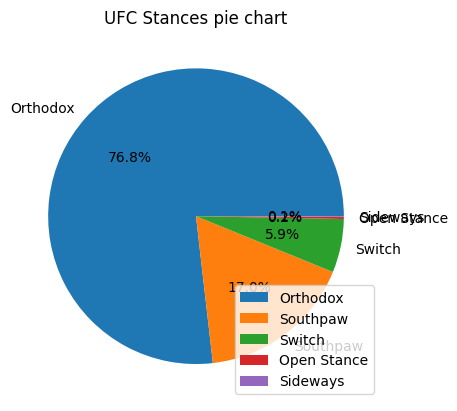

In [74]:
plt.pie(stance_counts, labels=stance_counts.index, autopct='%1.1f%%')
plt.title("UFC Stances pie chart")
plt.legend()

In [35]:
d.groupby(['Stance']).sum()

C:\Users\Miguel Sanka\AppData\Local\Temp\ipykernel_26124\577180090.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  d.groupby(['Stance']).sum()


,W,L,D,Ht. (m),Wt. (kg),Reach. (cm)
Stance,,,,,,
Open Stance,107,69,3,13.07,880.90,378.46
Orthodox,34101,15295,703,4467.40,197663.23,294797.48
Sideways,6,5,0,5.53,370.45,0.00
Southpaw,8234,3585,225,990.93,42930.91,70187.82
Switch,2254,840,35,343.51,13999.66,29951.68


In [42]:
def get_ufc_links() -> list:
    lista = []
    for let in range(ord('a'), ord('z') + 1):
        page = rq.get(f'http://ufcstats.com/statistics/fighters?char={chr(let)}&page=all')
        soup_prof = bs(page.content, "html.parser")
        a_tags = soup_prof.find_all("a", attrs={"class": "b-link b-link_style_black"})

        for e in a_tags:
            if e.get('href') not in lista:
                lista.append(e.get('href'))

    return lista

In [38]:
l = get_ufc_links()

In [39]:
l

['http://ufcstats.com/fighter-details/93fe7332d16c6ad9',
 'http://ufcstats.com/fighter-details/15df64c02b6b0fde',
 'http://ufcstats.com/fighter-details/59a9d6dac61c2540',
 'http://ufcstats.com/fighter-details/b361180739bed4b0',
 'http://ufcstats.com/fighter-details/3329d692aea4dc28',
 'http://ufcstats.com/fighter-details/2f5cbecbbe18bac4',
 'http://ufcstats.com/fighter-details/c0ed7b208197e8de',
 'http://ufcstats.com/fighter-details/5140122c3eecd307',
 'http://ufcstats.com/fighter-details/c9f6385af6df66d7',
 'http://ufcstats.com/fighter-details/aa6e591c2a2cdecd',
 'http://ufcstats.com/fighter-details/7279654c7674cd24',
 'http://ufcstats.com/fighter-details/f689bd7bbd14b392',
 'http://ufcstats.com/fighter-details/1c5879330d42255f',
 'http://ufcstats.com/fighter-details/989b85f6540c86b1',
 'http://ufcstats.com/fighter-details/2620f3eb21c79614',
 'http://ufcstats.com/fighter-details/83b00f7597e5ac83',
 'http://ufcstats.com/fighter-details/a77633a989013265',
 'http://ufcstats.com/fighter-d

In [40]:
len(l)

4129

In [43]:
def get_ufc_stats(lista: list) -> pd.DataFrame:
    df_stats = pd.DataFrame(columns=['DOB', 'SLpM', 'Str.Acc.', 'SApM', 'Str.Def', 'TDAvg.', 'TDAcc.', 'TDDef.', 'Sub.Avg.'])
    
    for url in lista:
        web = rq.get(url)
        soup = bs(web.content, "html.parser")
        li_tags = soup.find_all("li", attrs={"class": "b-list__box-list-item b-list__box-list-item_type_block"})

        data = []
        for i in range(4, len(li_tags)):
            data.append(li_tags[i].text.replace('\n', '').replace(' ', '').replace('%', '').strip())

        data.remove('')

        dic = {}
        for item in data:
            key, value = item.split(':')
            dic[key] = value

        df_stats = df_stats.append(dic, ignore_index=True)
    
    df_stats = df_stats.astype({"SLpM":"float64", "Str.Acc.":"float64", "SApM":"float64", "Str.Def":"float64", "TDAvg.":"float64", "TDAcc.":"float64",  "TDDef.":"float64", 'Sub.Avg.':"float64"})
    
    return df_stats

In [44]:
df2 = get_ufc_stats(l)

C:\Users\Miguel Sanka\AppData\Local\Temp\ipykernel_26124\1738084126.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_stats = df_stats.append(dic, ignore_index=True)
C:\Users\Miguel Sanka\AppData\Local\Temp\ipykernel_26124\1738084126.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_stats = df_stats.append(dic, ignore_index=True)
C:\Users\Miguel Sanka\AppData\Local\Temp\ipykernel_26124\1738084126.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_stats = df_stats.append(dic, ignore_index=True)
C:\Users\Miguel Sanka\AppData\Local\Temp\ipykernel_26124\1738084126.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_stat

In [46]:
df2

,DOB,SLpM,Str.Acc.,SApM,Str.Def,TDAvg.,TDAcc.,TDDef.,Sub.Avg.
0,"Jul13,1978",0.00,0.0,0.00,0.0,0.00,0.0,0.0,0.0
1,"Jul03,1983",3.29,38.0,4.41,57.0,0.00,0.0,77.0,0.0
2,"Feb01,1994",3.00,20.0,5.67,46.0,0.00,0.0,66.0,0.0
3,--,1.35,30.0,3.55,38.0,1.07,33.0,66.0,0.0
4,"Jan22,1993",3.87,52.0,3.13,59.0,3.00,75.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
4124,"Mar05,1980",0.00,0.0,0.00,0.0,0.00,0.0,0.0,0.0
4125,--,0.00,0.0,0.00,0.0,0.00,0.0,0.0,0.0
4126,--,7.64,38.0,5.45,37.0,0.00,0.0,100.0,0.0
4127,"Apr04,1992",3.93,52.0,1.80,61.0,0.00,0.0,57.0,1.0


In [47]:
df_ufc  = pd.concat([d, df2], axis=1)

In [53]:
df_ufc  = df_ufc.reindex(columns= ['First', 'Last', 'Nickname', 'Ht.', 'Wt.', 'Reach',  
                        'Ht. (m)', 'Wt. (kg)', 'Reach. (cm)', 'Stance', 'DOB', 'SLpM', 'Str.Acc.',
                        'SApM', 'Str.Def', 'TDAvg.', 'TDAcc.', 'TDDef.', 'Sub.Avg.', 'W', 'L', 'D'])

In [60]:
df_ufc.to_csv('ufc_data.csv')

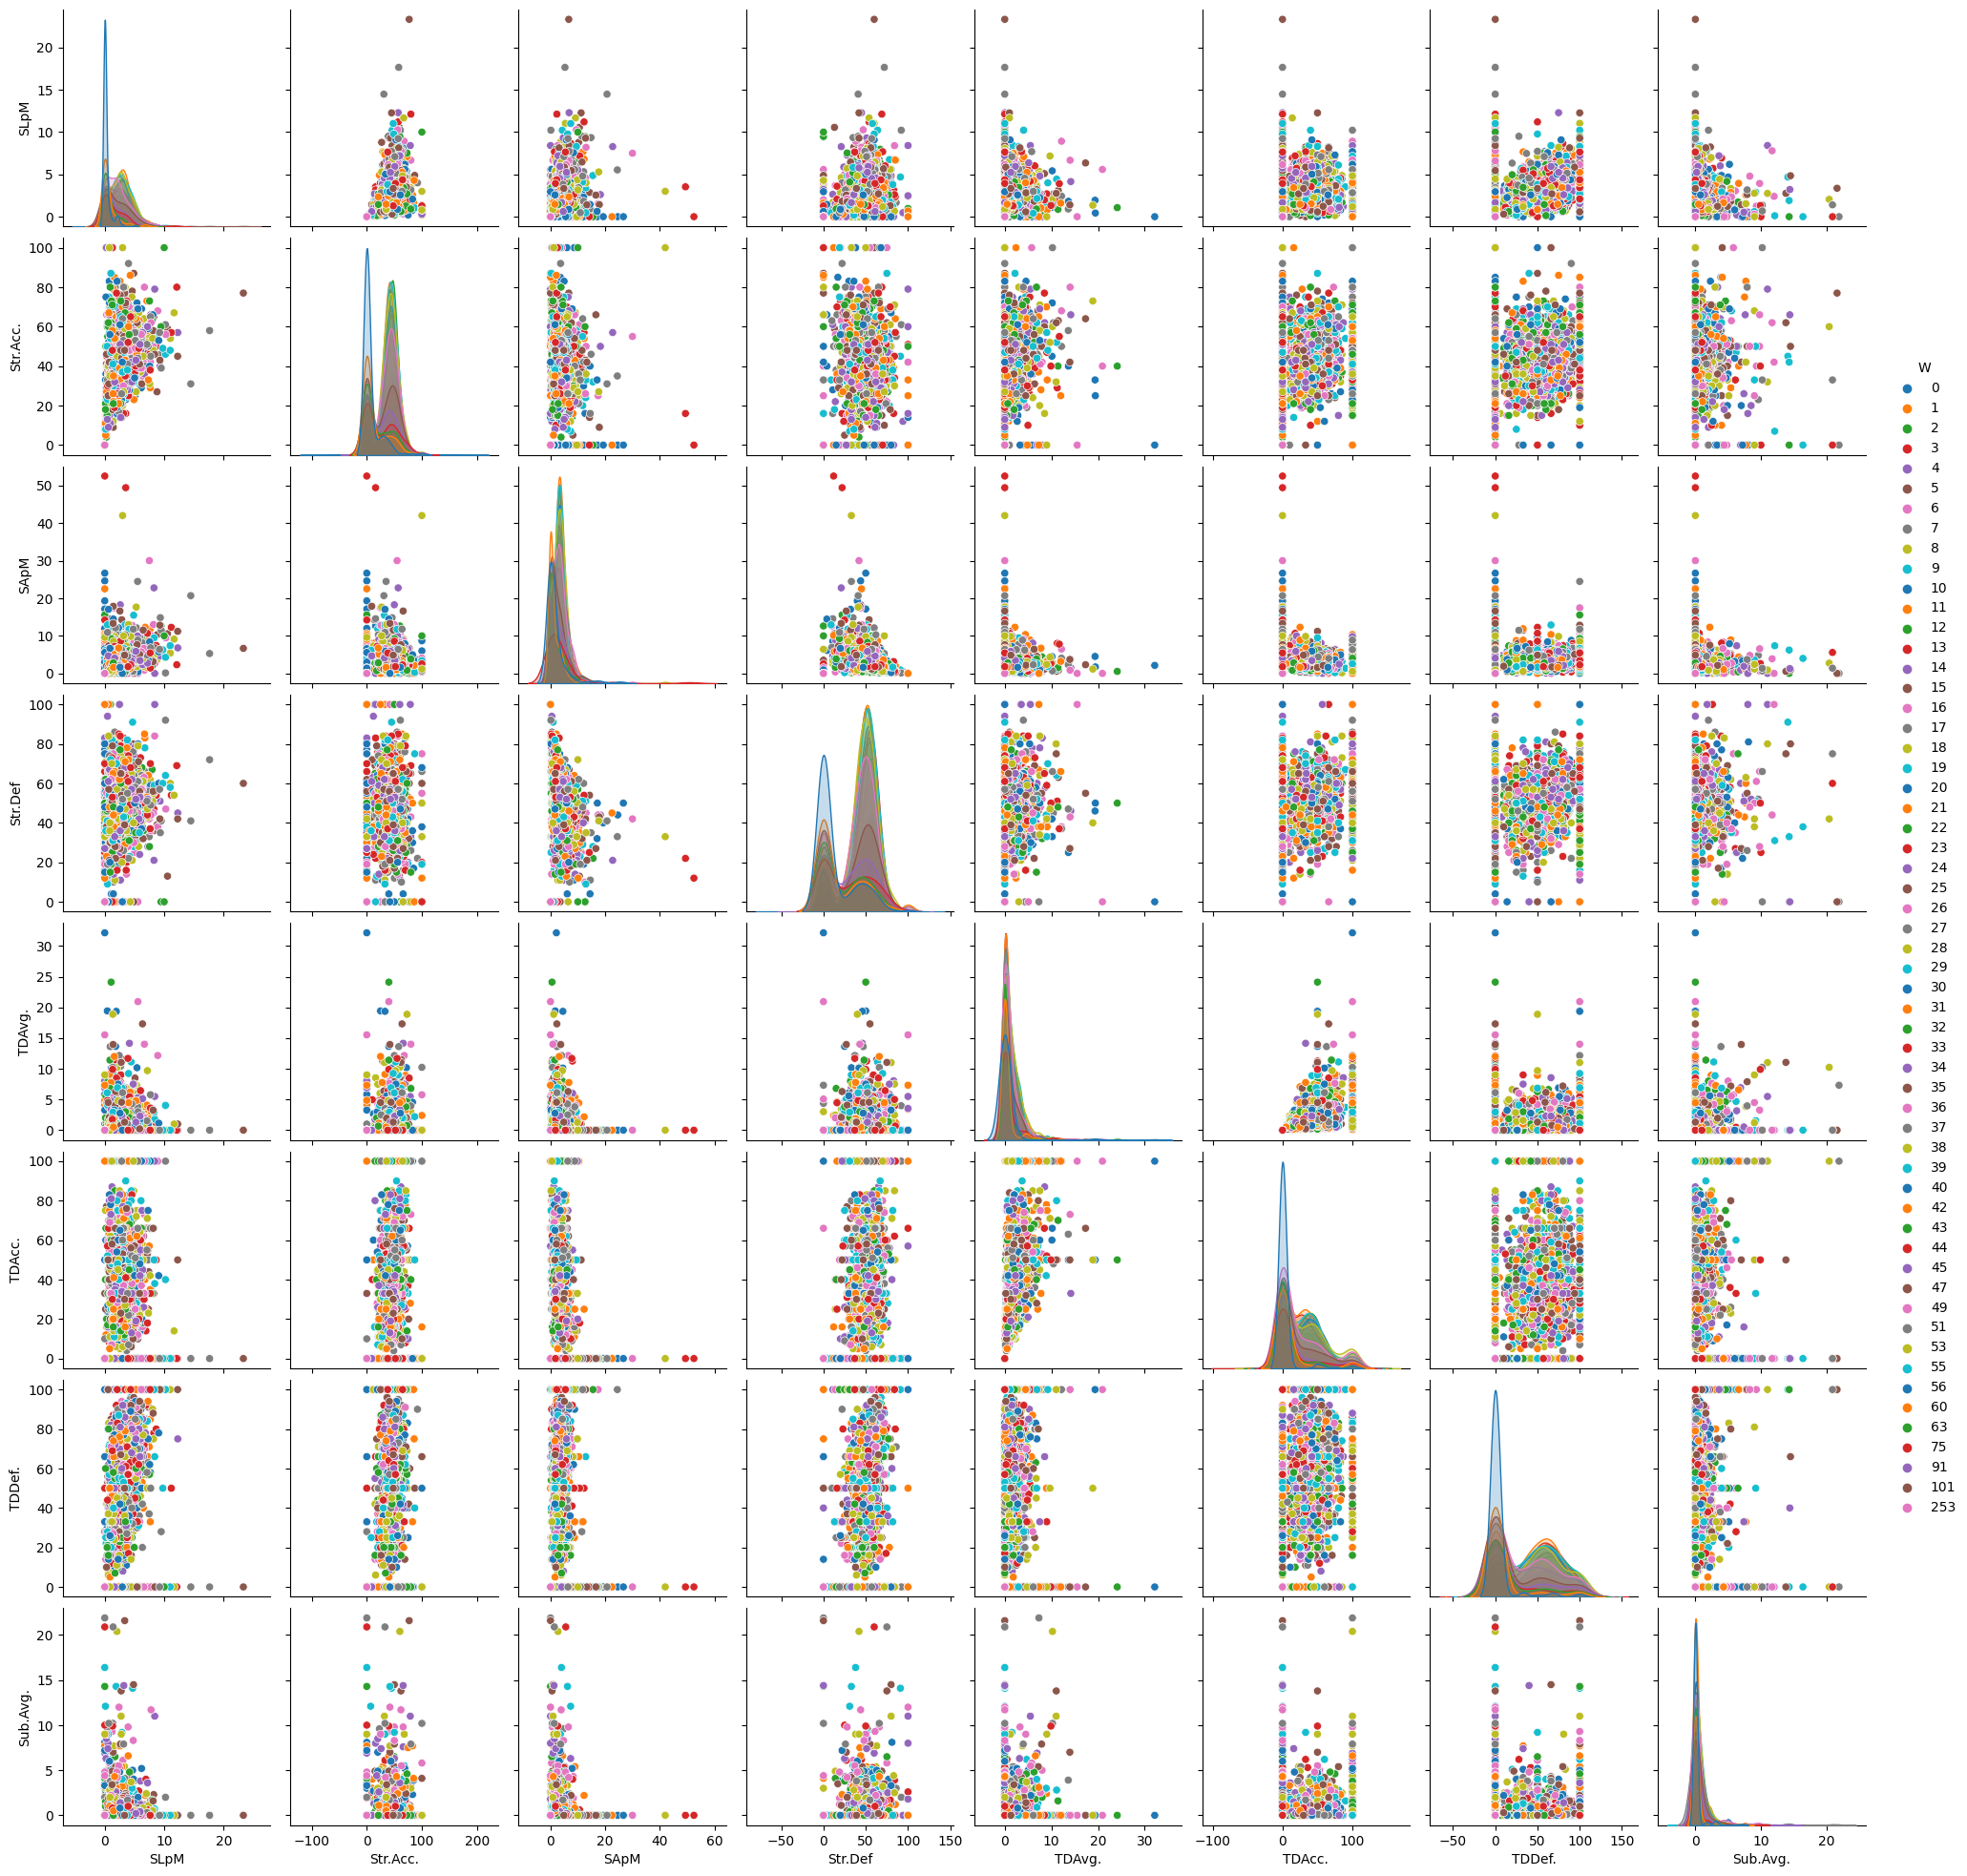

In [69]:
sns.pairplot(data=df_ufc, vars=['SLpM', 'Str.Acc.',
                    'SApM', 'Str.Def', 'TDAvg.', 'TDAcc.', 'TDDef.', 'Sub.Avg.'], hue='W', palette='tab10')
plt.show()


In [52]:
df_ufc.query("First == 'Jon'")

,First,Last,Nickname,Ht.,Wt.,Reach,Stance,W,L,D,...,Reach. (cm),DOB,SLpM,Str.Acc.,SApM,Str.Def,TDAvg.,TDAcc.,TDDef.,Sub.Avg.
863,Jon,Delos Reyes,The Heat,"5' 6""",125 lbs.,"67.0""",Orthodox,8,5,0,...,170.18,"Aug19,1987",2.99,38.0,4.14,51.0,3.20,83.0,55.0,1.9
1133,Jon,Fitch,NaN,"6' 0""",170 lbs.,"74.0""",Orthodox,30,7,1,...,187.96,"Feb24,1978",2.61,50.0,1.65,54.0,3.60,51.0,56.0,0.8
1545,Jon,Hess,NaN,"6' 7""",295 lbs.,--,NaN,1,1,0,...,NaN,--,0.00,0.0,0.00,0.0,0.00,0.0,0.0,0.0
1764,Jon,Jones,Bones,"6' 4""",248 lbs.,"84.0""",Orthodox,27,1,0,...,213.36,"Jul19,1987",4.29,57.0,2.22,64.0,1.93,45.0,95.0,0.5
2189,Jon,Madsen,NaN,"6' 0""",240 lbs.,"72.0""",Orthodox,8,2,0,...,182.88,"Feb12,1980",2.46,41.0,1.18,81.0,1.32,71.0,70.0,0.0
2239,Jon,Manley,NaN,"6' 1""",170 lbs.,--,Orthodox,9,4,0,...,NaN,"Jul07,1986",1.13,20.0,4.33,45.0,1.00,7.0,20.0,0.0
2563,Jon,Murphy,Man of Faith,"6' 3""",260 lbs.,--,Orthodox,6,4,0,...,NaN,"Aug09,1977",3.93,66.0,8.85,43.0,0.00,0.0,0.0,0.0
3780,Jon,Tuck,Super Saiyan,"5' 11""",155 lbs.,"73.0""",Orthodox,10,5,0,...,185.42,"Aug28,1984",3.00,40.0,3.74,60.0,0.42,33.0,50.0,1.0
